<a href="https://colab.research.google.com/github/soodeh-nilforoushan/NLP-Transformers/blob/main/10_Fine_Tuning_Sentiment_Custom_Dataset_%2B_Labels.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install transformers datasets

In [2]:
!wget -nc https://lazyprogrammer.me/course_files/AirlineTweets.csv


File ‘AirlineTweets.csv’ already there; not retrieving.



In [3]:
from transformers import AutoTokenizer
from datasets import load_dataset
import numpy as np
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt

import torch
from sklearn.metrics import f1_score,accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split

In [4]:
df_=pd.read_csv("AirlineTweets.csv")

In [5]:
df_.head()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)


In [6]:
df=df_[["airline_sentiment", "text"]].copy()

In [7]:
df.head()

,airline_sentiment,text
0,neutral,@VirginAmerica What @dhepburn said.
1,positive,@VirginAmerica plus you've added commercials t...
2,neutral,@VirginAmerica I didn't today... Must mean I n...
3,negative,@VirginAmerica it's really aggressive to blast...
4,negative,@VirginAmerica and it's a really big bad thing...


<Axes: >

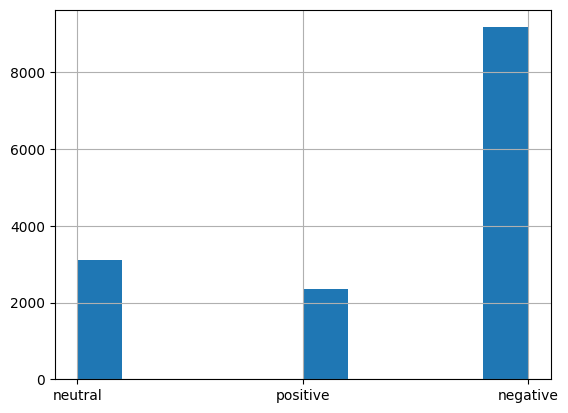

In [8]:
df["airline_sentiment"].hist()
#it is unbalance dataset

In [9]:
target_map={'positive':1,'negative':0, 'neutral':2}
df['target']=df['airline_sentiment'].map(target_map)

In [10]:
# df2=df[['target','text']].copy()
# df2.head()
df2=df[['text', 'target']]
df2.columns=['sentence','label']
df2.to_csv('data.csv', index=None)
df2.head()

,sentence,label
0,@VirginAmerica What @dhepburn said.,2
1,@VirginAmerica plus you've added commercials t...,1
2,@VirginAmerica I didn't today... Must mean I n...,2
3,@VirginAmerica it's really aggressive to blast...,0
4,@VirginAmerica and it's a really big bad thing...,0


In [11]:
!head data.csv

sentence,label
@VirginAmerica What @dhepburn said.,2
@VirginAmerica plus you've added commercials to the experience... tacky.,1
@VirginAmerica I didn't today... Must mean I need to take another trip!,2
"@VirginAmerica it's really aggressive to blast obnoxious ""entertainment"" in your guests' faces &amp; they have little recourse",0
@VirginAmerica and it's a really big bad thing about it,0
"@VirginAmerica seriously would pay $30 a flight for seats that didn't have this playing.
it's really the only bad thing about flying VA",0
"@VirginAmerica yes, nearly every time I fly VX this “ear worm” won’t go away :)",1
"@VirginAmerica Really missed a prime opportunity for Men Without Hats parody, there. https://t.co/mWpG7grEZP",2


In [12]:
#the same as above code
# df2=df[['text','target']].copy()
# df2.head()

In [13]:
#when we load data_datset, we can use it to load in our csv as a hugging faced dataset
from datasets import load_dataset
raw_dataset=load_dataset('csv',data_files='data.csv')

Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

In [14]:
raw_dataset

DatasetDict({
    train: Dataset({
        features: ['sentence', 'label'],
        num_rows: 14640
    })
})

In [15]:
split=raw_dataset['train'].train_test_split(test_size=0.3,seed=42)

In [16]:
split

DatasetDict({
    train: Dataset({
        features: ['sentence', 'label'],
        num_rows: 10248
    })
    test: Dataset({
        features: ['sentence', 'label'],
        num_rows: 4392
    })
})

In [17]:
#when we have multiple csv files
# raw_dataset=load_dataset('csv',data_files=['data.csv','files2.csv'])

In [18]:
checkpoint="distilbert-base-cased"

In [19]:
from transformers import AutoTokenizer

In [20]:
tokenizer=AutoTokenizer.from_pretrained(checkpoint)

In [21]:
def tokenize_fn(batch):
  #padding handled automatically by trainer
  return tokenizer(batch['sentence'], truncation=True)

In [22]:

#apply tokeize function in our train test split by using the map method
tokenized_datasets=split.map(tokenize_fn,batched=True)

Map:   0%|          | 0/10248 [00:00<?, ? examples/s]

Map:   0%|          | 0/4392 [00:00<?, ? examples/s]

In [23]:
tokenized_datasets

DatasetDict({
    train: Dataset({
        features: ['sentence', 'label', 'input_ids', 'attention_mask'],
        num_rows: 10248
    })
    test: Dataset({
        features: ['sentence', 'label', 'input_ids', 'attention_mask'],
        num_rows: 4392
    })
})

****
* we pass config object into pre-trained method
* config is similar to tokenizer is model specific that can be bert, GPT2 and etc.
* Autoconfig automatically chooses the right config object based on the check point that we give it
* we also can have automodel and autotokenizer. ****

In [24]:
from transformers import AutoModelForSequenceClassification,Trainer ,TrainingArguments,AutoModelForSequenceClassification, AutoConfig

In [25]:
config=AutoConfig.from_pretrained(checkpoint)

In [26]:
config

DistilBertConfig {
  "_name_or_path": "distilbert-base-cased",
  "activation": "gelu",
  "attention_dropout": 0.1,
  "dim": 768,
  "dropout": 0.1,
  "hidden_dim": 3072,
  "initializer_range": 0.02,
  "max_position_embeddings": 512,
  "model_type": "distilbert",
  "n_heads": 12,
  "n_layers": 6,
  "output_past": true,
  "pad_token_id": 0,
  "qa_dropout": 0.1,
  "seq_classif_dropout": 0.2,
  "sinusoidal_pos_embds": false,
  "tie_weights_": true,
  "transformers_version": "4.28.0",
  "vocab_size": 28996
}

In [27]:
config.id2label

{0: 'LABEL_0', 1: 'LABEL_1'}

In [28]:
config.label2id

{'LABEL_0': 0, 'LABEL_1': 1}

In [29]:
target_map

{'positive': 1, 'negative': 0, 'neutral': 2}

In [30]:
config.id2label={v:k for k, v in target_map.items()}
config.label2id=target_map

In [31]:
config.label2id

{'positive': 1, 'negative': 0, 'neutral': 2}

In [32]:
model= AutoModelForSequenceClassification.from_pretrained(
    checkpoint,config=config
)

Some weights of the model checkpoint at distilbert-base-cased were not used when initializing DistilBertForSequenceClassification: ['vocab_layer_norm.weight', 'vocab_projector.weight', 'vocab_transform.weight', 'vocab_transform.bias', 'vocab_layer_norm.bias', 'vocab_projector.bias']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-cased and are newly initialized: ['pre_classifier.weight', 'classifier.bias', 'classifier.wei

In [33]:
!pip install torchinfo

In [34]:
from torchinfo import summary

In [35]:
summary(model)

Layer (type:depth-idx)                                  Param #
DistilBertForSequenceClassification                     --
├─DistilBertModel: 1-1                                  --
│    └─Embeddings: 2-1                                  --
│    │    └─Embedding: 3-1                              22,268,928
│    │    └─Embedding: 3-2                              393,216
│    │    └─LayerNorm: 3-3                              1,536
│    │    └─Dropout: 3-4                                --
│    └─Transformer: 2-2                                 --
│    │    └─ModuleList: 3-5                             42,527,232
├─Linear: 1-2                                           590,592
├─Linear: 1-3                                           2,307
├─Dropout: 1-4                                          --
Total params: 65,783,811
Trainable params: 65,783,811
Non-trainable params: 0

In [36]:
!pip install datasets transformers==4.28.0

In [37]:
training_args=TrainingArguments(
    output_dir='training_dir',
    evaluation_strategy='epoch',
    save_strategy='epoch',
    num_train_epochs=3,
    per_device_train_batch_size=16, #specify batch file for training and eval
    per_device_eval_batch_size=64,
)


In [38]:
def compute_metrics(logits_and_labels):
  logits,labels=logits_and_labels
  predictions=np.argmax(logits,axis=-1)
  acc=np.mean(predictions==labels)
  f1=f1_score(labels,predictions,average='macro')
  return{'accuracy': acc, 'f1': f1}


In [39]:
trainer=Trainer(
    model,
    training_args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets['test'],
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
)

In [40]:
trainer.train()
#The training loss indicates how well the model is fitting the training data, while the validation loss indicates how well the model fits new data.

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
You're using a DistilBertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.540800,0.430966,0.829918,0.774571
2,0.351600,0.461143,0.831512,0.786560
3,0.247500,0.615521,0.835383,0.783910


TrainOutput(global_step=1923, training_loss=0.3330660268036698, metrics={'train_runtime': 199.5095, 'train_samples_per_second': 154.098, 'train_steps_per_second': 9.639, 'total_flos': 388376501242176.0, 'train_loss': 0.3330660268036698, 'epoch': 3.0})

In [41]:
!ls training_dir

checkpoint-1282  checkpoint-1923  checkpoint-641  runs


In [42]:
from transformers import pipeline

In [43]:
#we work with the best epoch which is the first epoch
savedmodel=pipeline('text-classification', model='training_dir/checkpoint-1282', device=0)

In [44]:
#how to access test
split['test']

Dataset({
    features: ['sentence', 'label'],
    num_rows: 4392
})

In [54]:
s=split['test']["sentence"][0]
print(s)
savedmodel(s)

@JetBlue thank you!


[{'label': 'positive', 'score': 0.9402056336402893}]

as a result the label is positive instead of label 1
we no longer need to manualy fix config file!